# EDA for Brain MRI

## Description

The primary objective of the case-study is to generate segmentation masks for brain MRI scans in the case of patients suffering from tumor genomic clusters as given in the LGG Segmentation Dataset.

This dataset contains brain MRI together with manual FLAIR abnormality segmentation masks. The images were obtained from The Cancer Imaging Archive (TCIA). They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.

## Import Packages

In [ ]:
import os
import cv2
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

from PIL import Image
from glob import glob
from mpl_toolkits.axes_grid import ImageGrid
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

## Exploratory Data Analysis

### Image-Mask Ratio

* Here we are trying to analyze if for every *image*, whether there exists a *mask* or not

In [ ]:
root = 'lgg-mri-segmentation/kaggle_3m/'
image_files = []
mask_files = glob(root + '*/*_mask*')
for image in mask_files:
  image_files.append(image.replace('_mask', ''))

In [ ]:
print("Total number of images: ", len(image_files))
print("Total number of masks: ", len(mask_files))

Total number of images:  3929
Total number of masks:  3929


In [ ]:
df = pd.DataFrame(list(zip(image_files, mask_files)), columns=['images', 'masks'])
df.head()

,images,masks
0,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...
1,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...
2,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...
3,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...
4,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...


In [ ]:
# df.to_csv('images_masks.csv', index=False)

In [ ]:
df = pd.read_csv('images_masks.csv')
df.head()

,images,masks
0,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...
1,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...
2,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...
3,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...
4,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  3929 non-null   object
 1   masks   3929 non-null   object
dtypes: object(2)
memory usage: 61.5+ KB


**OBSERVATION:**

*   Since we know that in the given dataset there are a total of 7858 TIF files present and from the above dataframe we observe that there are 3929 TIF files present for each of **images** and **masks**, hence we can conclude that for each MRI of a patient, there exists a corresponding mask for that image



### Positive-Negative Diagnosis

* Here we are trying to analyze that out of all the given samples, if there exists both positive and negative diagnosis

In [ ]:
# https://www.kaggle.com/bonhart/brain-mri-data-visualization-unet-fpn/output
def diagnosis(mask_path):
  thresh_value = np.max(cv2.imread(mask_path))
  if thresh_value > 0:
    return 1
  else:
    return 0

In [ ]:
df['diagnosis'] = df['masks'].progress_apply(lambda x : diagnosis(x))

In [ ]:
df.head()

,images,masks,diagnosis
0,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0
1,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0
2,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0
3,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0
4,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0


In [ ]:
# df.to_csv('images_masks_diagnosis.csv', index=False)

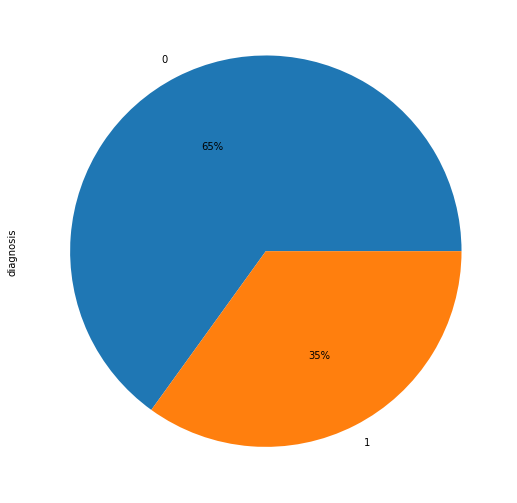

In [ ]:
# https://stackoverflow.com/questions/21572870/matplotlib-percent-label-position-in-pie-chart
df['diagnosis'].value_counts().plot(kind='pie', figsize=(9, 9), autopct='%1.0f%%');

**OBSERVATION:**

* Here we observe that 35% of all the masks have a positive (1) diagnosis and the remaining 65% have a negative (0) diagnosis 

In [ ]:
# https://www.kaggle.com/bonhart/brain-mri-data-visualization-unet-fpn/output
def diagnosis_masks(dataframe, diagnosis):
  sample = dataframe[dataframe['diagnosis'] == diagnosis].sample(5).values
  img_msk_list = []
  for value in sample:
    image = cv2.resize(cv2.imread(value[0]), (512, 512))
    mask = cv2.resize(cv2.imread(value[1]), (512, 512))
    img_msk_list.extend([image, mask])

  image_array = np.hstack(np.array(img_msk_list[::2]))
  mask_array = np.hstack(np.array(img_msk_list[1::2]))

  figure = plt.figure(figsize=(25, 25))
  grid = ImageGrid(figure, 111, nrows_ncols=(2,1), axes_pad=0.1)

  grid[0].imshow(image_array)
  grid[0].set_title('Images', fontsize=15)
  grid[0].axis('off')

  grid[1].imshow(mask_array)
  grid[1].set_title('Masks', fontsize=15)
  grid[1].axis('off')

  plt.show()

#### Positive Masks

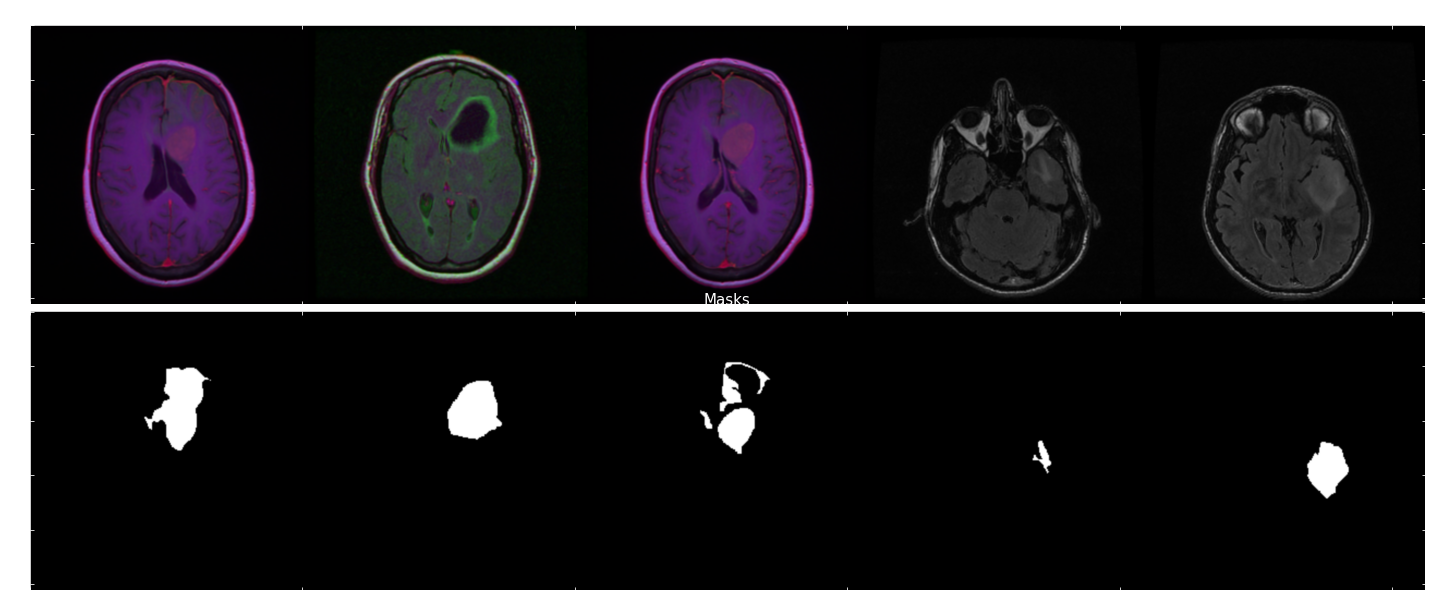

In [ ]:
diagnosis_masks(df, 1)

#### Negative Masks

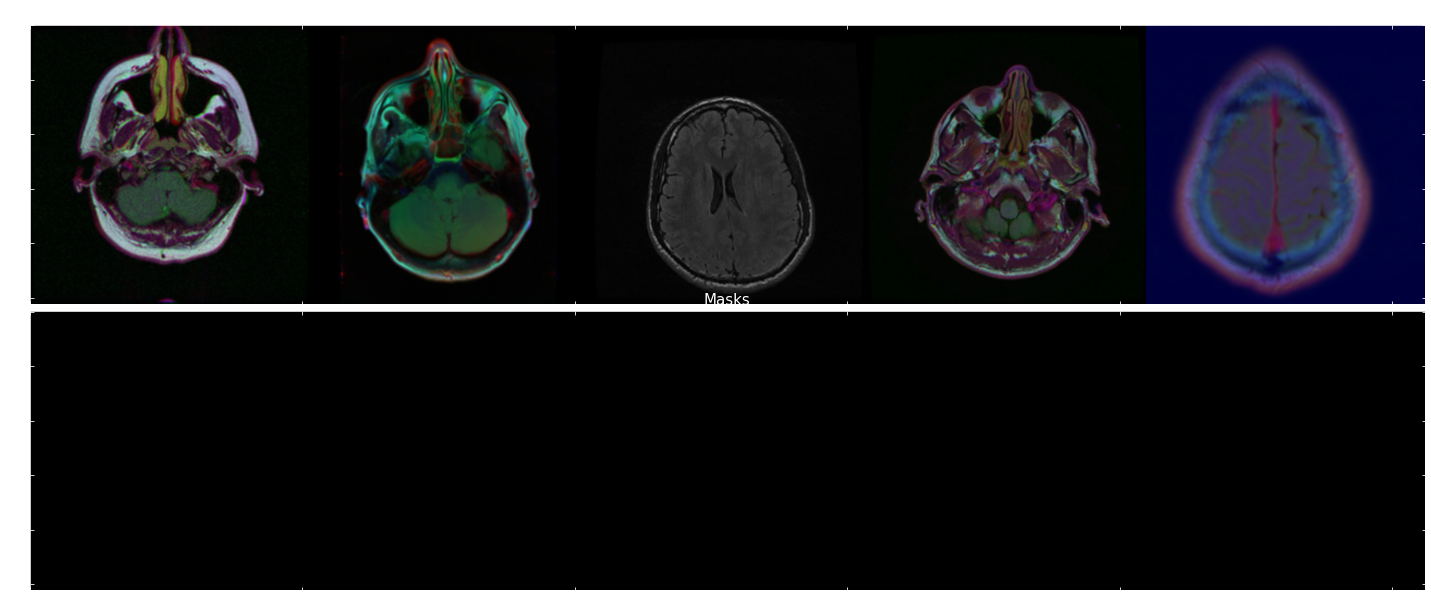

In [ ]:
diagnosis_masks(df, 0)

**OBSERVATION**

* Here we have observed that if the diagnosis is positive then we have a distinct segmentation present for the respective masks. But if the diagnosis is negative, then there is no segmentation present for the given masks